### Load data and predict

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [142]:
def show_result(X_test, y_pred, idx, show_image=False):
    #labels = ['Ac','As','Cb','Cc','Ci','Cs','Cu','Ns','Sc','St']
    labels = ['Ac','As','Cb','Cc','Ci','Cu','Sc','St']
    if show_image:
        plt.imshow(X_test[idx])
        plt.show()
    
    print("The classifier says that the image shown is from class -> {}".format(labels[np.argmax(y_pred[idx])]))
    
    return labels[np.argmax(y_pred[idx])]

In [143]:
from DataLoader import DataLoader

data = DataLoader()
data.load_data("/Users/marcosplazagonzalez/Desktop/Ground-based_CloudClassification/Datasets/FabraClouds256_TrainTest_Clean/test/", 256, 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


In [144]:
from keras.models import load_model
model = load_model('./Models/Test12_FabraClouds256_TrainTest_Clean_1e-3_PreImagenetTrainable_noAug.h5')

In [145]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         327936    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 4,684,232
Trainable params: 4,650,120
Non-trainable params: 34,112
_________________________________________

In [146]:
y_pred = model.predict(data.X)

2022-06-30 16:40:50.769343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [147]:
y_pred.shape

(659, 8)

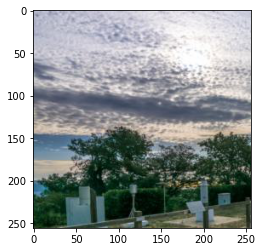

The classifier says that the image shown is from class -> Cc


'Cc'

In [148]:
show_result(data.X, y_pred, 190, show_image=True)

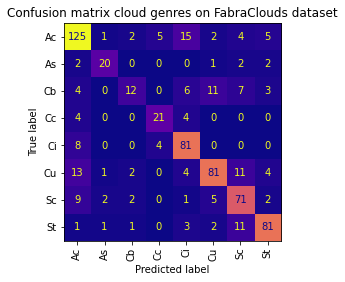

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

matrix = confusion_matrix(data.y.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data.class_names)
disp.plot(colorbar=False, cmap='plasma', xticks_rotation='vertical')
plt.title("Confusion matrix cloud genres on FabraClouds dataset")
plt.show()

In [134]:
report = classification_report(data.y.argmax(axis=1), y_pred.argmax(axis=1), target_names=data.class_names)
print(report) 

              precision    recall  f1-score   support

          Ac       0.75      0.79      0.77       159
          As       0.80      0.74      0.77        27
          Cb       0.63      0.28      0.39        43
          Cc       0.70      0.72      0.71        29
          Ci       0.71      0.87      0.78        93
          Cu       0.79      0.70      0.74       116
          Sc       0.67      0.77      0.72        92
          St       0.84      0.81      0.82       100

    accuracy                           0.75       659
   macro avg       0.74      0.71      0.71       659
weighted avg       0.75      0.75      0.74       659



### Conformal Prediction

In [138]:
p_max = np.array([y_pred[i,v] for i,v in enumerate(data.y.argmax(axis=1))]) 
conformal_scores = 1. - p_max

alpha = 0.05
n = len(conformal_scores)
q_hat = np.quantile(conformal_scores, (n+1) * (1. - alpha) / n)

In [139]:
names = {0:'Ac',1:'As',2:'Cb',3:'Cc',4:'Ci',5:'Cu',6:'Sc',7:'St'}

{'Sc': 0.99884444, 'St': 0.0011426698}


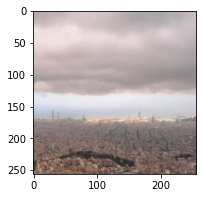

{'Ac': 0.01628489, 'Cb': 0.12012332, 'Ci': 0.01465828, 'Cu': 0.2743112, 'Sc': 0.5732123, 'St': 0.0013108017}


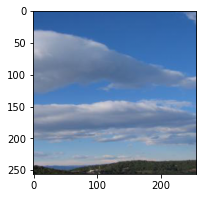

{'Ac': 0.012348957, 'As': 0.053097285, 'Cu': 0.0017042533, 'Sc': 0.5728231, 'St': 0.3595768}


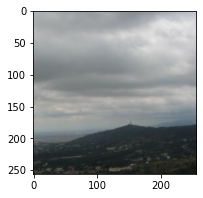

{'Ac': 0.122975625, 'As': 0.04055658, 'Sc': 0.8355203}


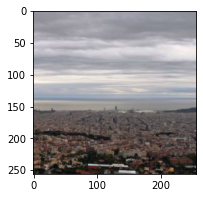

{'Ac': 0.0033766965, 'Cb': 0.96174455, 'Ci': 0.004779338, 'Cu': 0.025107749, 'Sc': 0.0049318112}


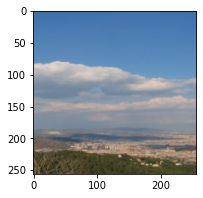

Theoretical Calibration =  0.95
Emphirical Calibration of 10 images =  1.0


In [140]:
cont = 0.
N = 10
for i in range(0,N):
    sel = {j:k for j,k in enumerate(y_pred[i]) if k > (1. - q_hat)}
    if data.y[i].argmax() in sel:
        cont += 1.
    if len(sel) < 2:
        continue
    ax = plt.figure(figsize=(3,3))
    plt.imshow(data.X[i])
    print('No selected class' if len(sel) == 0 else {names[j]:sel[j] for j in sel.keys()})
    plt.show()

print("Theoretical Calibration = ",1.-alpha)
print("Emphirical Calibration of "+str(N)+" images = ",cont/N)

In [93]:
from tqdm import tqdm
emph_cal = []
N = 20
for alpha in tqdm(np.arange(0.05,1.,0.05)):
    n = len(conformal_scores)
    q_hat = np.quantile(conformal_scores, (n+1) * (1. - alpha) / n)
    cont = 0.
    for i in range(0,N):
        sel = {j:k for j,k in enumerate(y_pred[i]) if k > (1. - q_hat)}
        if data.y[i].argmax() in sel:
            cont += 1.
    emph_cal += [cont]
emph_cal = np.array(emph_cal)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3275.86it/s]


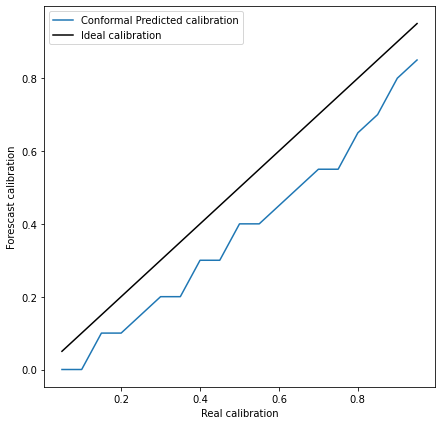

In [94]:
plt.figure(figsize=(7,7))
plt.plot(1-np.arange(0.05,1.,0.05),emph_cal/N,label='Conformal Predicted calibration')
plt.plot(1-np.arange(0.05,1.,0.05),1-np.arange(0.05,1.,0.05),color='black',label='Ideal calibration')
plt.ylabel('Forescast calibration')
plt.xlabel('Real calibration')
plt.legend()
plt.show()